# Example of training an INR locally
This notebook provides an example of how to create an INR and train it locally using the tools in this repo.

In [1]:
import pdb
import traceback

import jax
from jax import numpy as jnp
import optax
import wandb

from common_dl_utils.config_creation import Config
import common_jax_utils as cju

wandb.login()

key = jax.random.PRNGKey(12398)
key_gen = cju.key_generator(key)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: maxwell_litsios (bep-circle). Use `wandb login --relogin` to force relogin
2024-11-26 19:31:04.207943: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.3 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


We want to train a single INR on `example_data/parrot.png`. We'll use the `CombinedINR` clas from `model_components.inr_modules` together with the `SirenLayer` and `GaussianINRLayer` from `model_components.inr_layers` for the model, and we'll train it using the tools from `inr_utils`.

To do all of this, basically we only need to create a config. We'll use the `common_dl_utils.config_creation.Config` class for this, but this is basically just a dictionary that allows for attribute access-like acces of its elements (so we can do `config.model_type = "CombinedINR"` instead of `config["model_type"] = "CombinedINR"`). You can also just use a dictionary instead.

Then we'll use the tools from `common_jax_utils` to first get a model from this config so we can inspect it, and then just run the experiment specified by the config.

Doing this in a config instead of hard coded might seem like extra work, but consider this:
1. you can serialize this config as a json file or a yaml file to later get the same model and experimental settings back 
   so when you are experimenting with different architectures, if you just store the configs you've used, you can easily recreate previous results
2. when we get to running hyper parameter sweeps, you can easily get these configs (with a pick for the varying hyper parameters) from wandb
   and then run an experiment specified by that config on any machine you want, e.g. on Snellius

In [2]:
config = Config()

# first we specify what the model should look like
config.architecture = './model_components'  # module containing all relevant classes for architectures
# NB if the classes relevant for creating the model are spread over multiple modules, this is no problem
# let config.architecture be the module that contains the "main" model class, and for all other components just specify the module
# or specify the other modules as default modules to the tools in common_jax_utils.run_utils
config.model_type = 'inr_modules.CombinedINR'

config.model_config = Config()
config.model_config.in_size = 2
config.model_config.out_size = 3
config.model_config.terms = [  # CombinedINR uses multiple MLPs and returns the sum of their outputs. These 'terms' are the MLPs
    ('inr_modules.MLPINR.from_config',{
        'hidden_size': 256,
        'num_layers': 5,
        'layer_type': 'inr_layers.ComplexWIRE',
        'num_splits': 1,
        'use_complex': False,
        'activation_kwargs': {'w0': 5, 's0':20}
    }),
    # ('inr_modules.MLPINR.from_config',{
    #     'hidden_size': 1024,
    #     'num_layers': 2,
    #     'num_splits': 1,
    #     'layer_type': 'inr_layers.GaussianINRLayer',
    #     'use_complex': False,
    #     'activation_kwargs': {'inverse_scale': 1},
    # })
]

# next, we set up the training loop, including the 'target_function' that we want to mimic
config.trainer_module = './inr_utils/'  # similarly to config.architecture above, here we just specify in what module to look for objects by default
config.trainer_type = 'training.train_inr'
config.target_function = 'images.ContinuousImage'
config.target_function_config = {
    'image': './example_data/parrot.png',
    'scale_to_01': True,
    'interpolation_method': 'images.make_piece_wise_constant_interpolation'
}
config.loss_function = 'losses.scaled_mse_loss'
config.sampler = ('sampling.GridSubsetSampler',{  # samples coordinates in a fixed grid, that should in this case coincide with the pixel locations in the image
    'size': [2040, 1356],
    'batch_size': 2000,
    'allow_duplicates': False,
})

config.optimizer = 'adam'  # we'll have to add optax to the additional default modules later
config.optimizer_config = {
    'learning_rate': 1.5e-4
}
config.steps = 400 #changed from 40000
config.use_wandb = True

# now we want some extra things, like logging, to happen during training
# the inr_utils.training.train_inr function allows for this through callbacks.
# The callbacks we want to use can be found in inr_utils.callbacks
config.after_step_callback = 'callbacks.ComposedCallback'
config.after_step_callback_config = {
    'callbacks':[
        ('callbacks.print_loss', {'after_every':400}),  # only print the loss every 400th step
        'callbacks.report_loss',  # but log the loss to wandb after every step
        ('callbacks.MetricCollectingCallback', # this thing will help us collect metrics and log images to wandb
             {'metric_collector':'metrics.MetricCollector'}
        ),
        'callbacks.raise_error_on_nan'  # stop training if the loss becomes NaN
    ],
    'show_logs': False
}

config.metric_collector_config = {  # the metrics for MetricCollectingCallback / metrics.MetricCollector
    'metrics':[
        ('metrics.PlotOnGrid2D', {'grid': 256, 'batch_size':8*256, 'frequency':'every_n_batches'}),  
        # ^ plots the image on this fixed grid so we can visually inspect the inr on wandb
        ('metrics.MSEOnFixedGrid', {'grid': [2040, 1356], 'batch_size':2040, 'frequency': 'every_n_batches'})
        # ^ compute the MSE with the actual image pixels
    ],
    'batch_frequency': 400,  # compute all of these metrics every 400 batches
    'epoch_frequency': 1  # not actually used
}

config.after_training_callback = None  # don't care for one now, but you could have this e.g. store some nice loss plots if you're not using wandb 
config.optimizer_state = None  # we're starting from scratch

In [3]:
# let's first see if we get the correct model
try:
    inr = cju.run_utils.get_model_from_config_and_key(
        prng_key=next(key_gen),
        config=config,
        model_sub_config_name_base='model',
        add_model_module_to_architecture_default_module=False, # since the model is already in the default module specified by 'architecture',
    )
except Exception as e:
    traceback.print_exc()
    print(e)
    print('\n')
    pdb.post_mortem()

In [4]:
inr

CombinedINR(
  terms=(
    MLPINR(
      input_layer=ComplexWIRE(
        weights=f32[256,2],
        biases=f32[256],
        activation_kwargs={'w0': 5, 's0': 20}
      ),
      hidden_layers=[
        ComplexWIRE(
          weights=c64[256,256],
          biases=c64[256],
          activation_kwargs={'w0': 5, 's0': 20}
        ),
        ComplexWIRE(
          weights=c64[256,256],
          biases=c64[256],
          activation_kwargs={'w0': 5, 's0': 20}
        ),
        ComplexWIRE(
          weights=c64[256,256],
          biases=c64[256],
          activation_kwargs={'w0': 5, 's0': 20}
        )
      ],
      output_layer=Linear(
        weights=f32[3,256],
        biases=f32[3],
        activation_kwargs={}
      ),
      post_processor=<function real_part>
    ),
  ),
  post_processor=<function real_part>
)

In [5]:
# check that it works properly
inr(jnp.zeros(2))

Array([ 0.89155525, -0.11254398, -0.6999613 ], dtype=float32)

In [6]:
# next we get the experiment from the config using common_jax_utils.run_utils.get_experiment_from_config_and_key
experiment = cju.run_utils.get_experiment_from_config_and_key(
    prng_key=next(key_gen),
    config=config,
    model_kwarg_in_trainer='inr',
    model_sub_config_name_base='model',  # so it looks for "model_config" in config
    trainer_default_module_key='trainer_module',  # so it knows to get the module specified by config.trainer_module
    additional_trainer_default_modules=[optax],  # remember the don't forget to add optax to the default modules? This is that 
    add_model_module_to_architecture_default_module=False,
    initialize=False  # don't run the experiment yet, we want to use wandb
)

/home/ovindar/PycharmProjects/INR_BEP/.venv/lib/python3.10/site-packages/jax/_src/lax/lax.py:3227: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


Loss at step 400 is 0.7430518865585327.


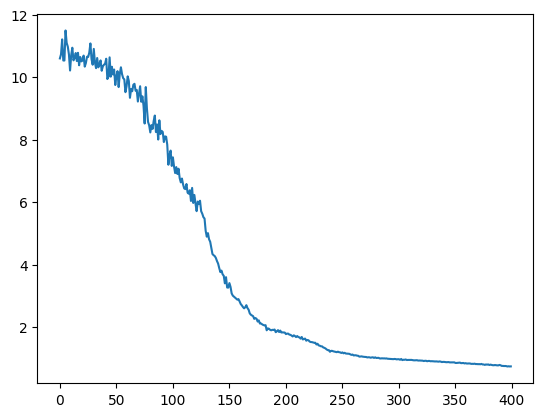

wandb: ERROR Control-C detected -- Run data was not synced


KeyboardInterrupt: 

In [7]:
# and we run the experiment while logging things to wandb
with wandb.init(
    project='inr_edu_24',
    notes='test',
    tags=['test']
) as run:
    results = experiment.initialize()